In [3]:
# Importing Libraries
import os
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
from wrf import getvar, interplevel, to_np, CoordPair, get_cartopy, latlon_coords
from netCDF4 import Dataset
from scipy.ndimage import gaussian_filter

In [7]:
data_dir = '/Volumes/Ann/wrf_100%/'
file_list = sorted([f for f in os.listdir(data_dir) if f.startswith("wrfout_d02")])
file_list = file_list[14:45]
print(file_list)
print(np.shape(file_list))

['wrfout_d02_2008-03-07_02:00:00', 'wrfout_d02_2008-03-07_03:00:00', 'wrfout_d02_2008-03-07_04:00:00', 'wrfout_d02_2008-03-07_05:00:00', 'wrfout_d02_2008-03-07_06:00:00', 'wrfout_d02_2008-03-07_07:00:00', 'wrfout_d02_2008-03-07_08:00:00', 'wrfout_d02_2008-03-07_09:00:00', 'wrfout_d02_2008-03-07_10:00:00', 'wrfout_d02_2008-03-07_11:00:00', 'wrfout_d02_2008-03-07_12:00:00', 'wrfout_d02_2008-03-07_13:00:00', 'wrfout_d02_2008-03-07_14:00:00', 'wrfout_d02_2008-03-07_15:00:00', 'wrfout_d02_2008-03-07_16:00:00', 'wrfout_d02_2008-03-07_17:00:00', 'wrfout_d02_2008-03-07_18:00:00']
(17,)


ISOCHRONE

- Load a 2D matrix of surface pressure values for each time step from the dataset.
- Extract and store the 2D pressure values fields into a 3D array or list indexed over time.
- Define spatial bounds to focus on a specific region within the domain (wave focus area).
- Subtract a time-averaged (e.g., 10-hour mean) baseline from the full time series to isolate pressure perturbations at each grid point.
- Apply a temporal smoothing filter (e.g., Gaussian) to reduce noise in the perturbation pressure signal.
- Determine the time steps where the smoothed signal first exceeds the threshold indicating potential wave events.
plot the time

In [12]:
from tqdm import tqdm

all_sfc = []
all_u10= []

for file_name in tqdm(file_list):
    file_path = os.path.join(data_dir, file_name)
    try:
        with Dataset(file_path, "r") as ncfile:
             sfc = to_np(getvar(ncfile, "PSFC"))/100
             all_sfc.append(sfc)
             u10 = to_np(getvar(ncfile, "U10"))
             all_u10.append(u10)
    except OSError as e:
        print(f"Skipping file {file_name}: {e}")

np.save("sfc.npy", to_np(all_sfc))
np.save("u10.npy", to_np(all_u10))



100%|██████████| 17/17 [00:02<00:00,  7.17it/s]


In [17]:
print(all_sfc)
print(all_u10)
print(type(all_sfc))

[[[1015.8696  1015.8591  1015.844   ...  976.2874   976.21295  976.43506]
  [1015.8858  1015.8695  1015.853   ...  975.82086  975.7494   976.02734]
  [1015.89923 1015.88135 1015.8604  ...  975.44244  975.4101   975.85767]
  ...
  [ 855.142    858.5832   859.9397  ... 1001.5974  1001.68866 1001.8622 ]
  [ 848.00226  851.0122   852.1736  ... 1001.745   1001.8814  1002.20013]
  [ 842.07135  844.4761   845.356   ... 1002.07794 1002.2592  1002.6316 ]]

 [[1016.29834 1016.3052  1016.3131  ...  976.7687   976.71405  976.9564 ]
  [1016.312   1016.32117 1016.3315  ...  976.2749   976.2422   976.5268 ]
  [1016.327   1016.3373  1016.3463  ...  975.8638   975.8767   976.3362 ]
  ...
  [ 855.60944  859.0394   860.40826 ... 1001.9645  1002.0786  1002.3161 ]
  [ 848.46295  851.4546   852.62494 ... 1002.1032  1002.2534  1002.6309 ]
  [ 842.53375  844.93005  845.80774 ... 1002.4602  1002.6566  1003.04224]]

 [[1016.8594  1016.8538  1016.8486  ...  977.0979   977.04865  977.29584]
  [1016.87494 1016.868

In [14]:
from datetime import datetime, timedelta
import pandas as pd

start_time = datetime(2008, 3, 7, 2, 0, 0)
end_time = datetime(2008, 3, 7, 18, 0, 0)

time_array = pd.date_range(start=start_time, end=end_time, freq="H")
t_plot = pd.to_datetime(time_array)
print(t_plot.shape)
print(type(t_plot))
print(t_plot)

(17,)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2008-03-07 02:00:00', '2008-03-07 03:00:00',
               '2008-03-07 04:00:00', '2008-03-07 05:00:00',
               '2008-03-07 06:00:00', '2008-03-07 07:00:00',
               '2008-03-07 08:00:00', '2008-03-07 09:00:00',
               '2008-03-07 10:00:00', '2008-03-07 11:00:00',
               '2008-03-07 12:00:00', '2008-03-07 13:00:00',
               '2008-03-07 14:00:00', '2008-03-07 15:00:00',
               '2008-03-07 16:00:00', '2008-03-07 17:00:00',
               '2008-03-07 18:00:00'],
              dtype='datetime64[ns]', freq='h')


/var/folders/rd/20pn3tk11j93kyzv8nw3djch0000gn/T/ipykernel_94758/1719901762.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_array = pd.date_range(start=start_time, end=end_time, freq="H")


In [15]:
all_sfc= np.array(all_sfc)
all_u10= np.array(all_u10)
time = np.arange(all_sfc.shape[0]) 

In [20]:
print(all_sfc.shape)
print(all_u10.shape)
print(type(all_sfc))
print(type(all_u10))

(17, 548, 624)
(17, 548, 624)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
filename ='/Volumes/Ann/wrf_100%/wrfout_d02_2008-03-06_12:00:00'
ncfile = Dataset(filename)
sfc= getvar(ncfile, "PSFC")/100
lat, lon = latlon_coords(sfc)  # Latitude and longitude
lat_np= to_np(lat)
lon_np= to_np(lon)

In [59]:
# Xarray provides rolling(dim, window) for easy time-based filtering, avoiding explicit loops.
# Create xarray DataArray
import xarray as xr
all_sfc_xr = xr.DataArray(all_sfc, dims=("time","lat", "lon"), coords={"time": time_array})
all_u_xr = xr.DataArray(all_u10, dims=("time","lat", "lon"), coords={"time": time_array})

window =10 # Define rolling window size
def remove_slow_trend_xr(data_xr, window):
    return data_xr.rolling(time=window, center=True, min_periods=2).mean() # Minimum number of non-NaN values required to compute a result. 

# Compute moving averages
moving_average_all_sfc = remove_slow_trend_xr(all_sfc_xr, window)
all_sfc_diff = all_sfc_xr - moving_average_all_sfc
all_sfc_diff_np = all_sfc_diff.values # Extract direct .values 
 
moving_average_all_u = remove_slow_trend_xr(all_u_xr, window)
all_u_diff = all_u_xr - moving_average_all_u
all_u_diff_np = all_u_diff.values

all_sfc_diff.shape
type(all_sfc_diff)

xarray.core.dataarray.DataArray

In [137]:
# Apply Gaussian filter
sfc_filled_smooth = gaussian_filter(all_sfc_diff_np, sigma= 1.5, mode='nearest')  # 'nearest' prevents edge shrinkage , (0,2,2) for time, lat, lon
sfc_filled_smooth.shape


(17, 548, 624)

In [138]:
# 2D slicing, remmeber not to use 'where' as it flattens the data but use the 2D mask and select using meshgrid:
lon_min, lon_max = -99.83, -89.0  
lat_min, lat_max = 26.22, 34.5   

masked_sfc_sub = np.copy(sfc_filled_smooth) 
mask = (lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max)
masked_sfc_sub[:, ~mask] = np.nan

In [139]:
# Coordinates for Beeville, Victoria, and Sugarland
locations = {
    "HEB": (27.30, -98.70),
    "BEV": (28.39, -97.740),
    "VCT": (28.822003, -96.983117),
    "SGR": (29.596031, -95.640973),

    "LCH": (30.1692, -93.2961),
    "LFT": (30.1442, -92.0996),
    "JAN": (32.2152, -90.3202),
    "GWO": (33.474, -90.2345)
}


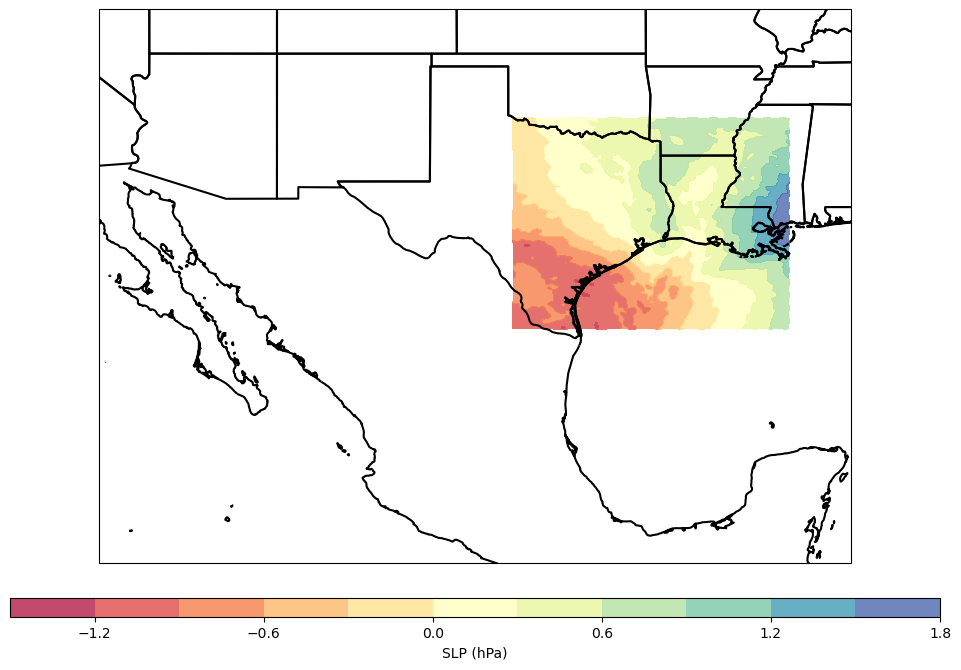

In [140]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m', linewidth=1.5)
ax.add_feature(cfeature.STATES, linewidth=1.5)
contour2 = ax.contourf(lon_np, lat_np, masked_sfc_sub[2, :, :], cmap="Spectral",alpha=0.8, levels=10, transform=ccrs.PlateCarree())
cbar = plt.colorbar(contour2, ax=ax, orientation="horizontal", label="SLP (hPa)", pad=0.05, aspect=50)
plt.show()

In [ ]:
time_of_arrival = np.full((548, 624), np.nan)
lowest_slp = np.min(masked_sfc_sub, axis=0)   #is used to ignore NaN values

for i in range(548):
    for j in range(624):
        for t in range(masked_sfc_sub.shape[0]):  
            if np.abs(masked_sfc_sub[t, i, j] - lowest_slp[i, j]) < 1e-3:  
                time_of_arrival[i, j] = t  
                break  

# optimizing the time_of_arrival array
time_of_arrival = np.argmin(masked_sfc_sub, axis=0)


In [145]:
time_smooth = gaussian_filter(time_of_arrival, sigma=4, mode='nearest')  # 'nearest' prevents edge shrinkage
time_smooth.shape

(548, 624)

In [146]:
# Define your simulation start time
start_time = pd.to_datetime("2008-03-07 02:00:00")  # Start time
def format_time(value):
    """Convert numerical time to hh format."""
    time_val = start_time + pd.to_timedelta(value * 1, unit="h")  
    return time_val.strftime("%H")  # Format as hh and also "string format time"

# test the function
format_time(0)

'02'

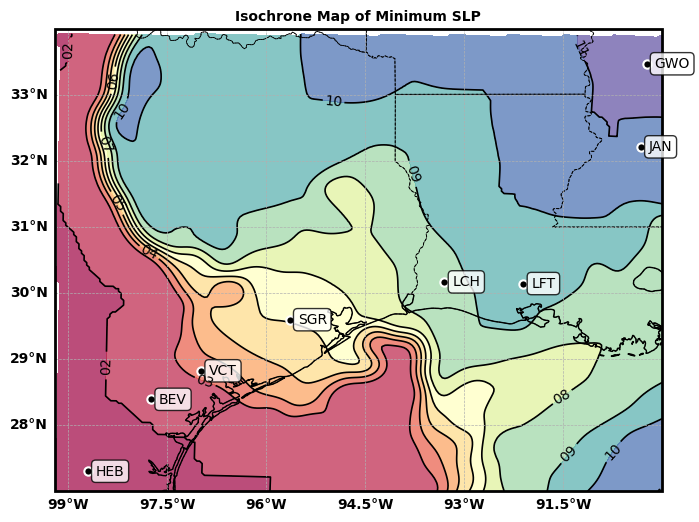

In [150]:
# Define the extent of the map
lon_min, lon_max = -99.2,-90  
lat_min, lat_max = 27, 34  

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()}) # Extra settings passed to each subplot as keyword arguments
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=1.0)  # These do not require specifying a projection again: they use the axes’ built-in projection.
ax.add_feature(cfeature.STATES, linewidth=0.6, linestyle="--") # ''
contour_levels = np.arange(np.nanmin(time_smooth), np.nanmax(time_smooth), 1)
cmap = plt.get_cmap("Spectral")
cf = ax.contourf(lon_np, lat_np, time_smooth, levels=contour_levels, cmap=cmap, extend="both", alpha=0.7)
cs = ax.contour(lon_np, lat_np, time_smooth, levels=contour_levels, colors="black", linewidths=1.2)
ax.clabel(cs, inline=True, fontsize=10, fmt=format_time)  

for location, (lat_city, lon_city) in locations.items():
    ax.plot(lon_city, lat_city, marker='o', markeredgecolor='white', markeredgewidth=1.5, 
            color='black', markersize=6, transform=ccrs.PlateCarree())    
    ax.text(lon_city + 0.12, lat_city, location, transform=ccrs.PlateCarree(),
            ha='left', va='center', fontsize=10, color='black',
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.3'))
for spine in ax.spines.values():
        spine.set_linewidth(2)

# Add gridlines.
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle="--")
gridlines.right_labels = False  # Hide right-side labels.
gridlines.top_labels = False    # Hide top labels.

plt.rcParams.update({
        'font.size': 10,
        'font.weight': 'bold',
        'axes.labelsize': 10,
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.titleweight': 'bold'
        })
ax.set_title("Isochrone Map of Minimum SLP", fontsize=10)
plt.show()